In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from PIL import Image
import os
import cv2
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from skimage import exposure

In [2]:
trainingDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_1/hem'
trainingDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_1/all'


validationDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_0/hem'
validationDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_0/all'

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.bmp')]

In [4]:
def dataImport(path,pathType):
    imageList = []
    for i,j in zip(pathType,path):
        if i not in ['ALL','HEM']:
            raise ValueError("Entry must be either 'ALL' or 'HEM'")
        else:
            if i == 'HEM':
                loadPath = get_imlist(j) 
                for paths in loadPath:
                    imageList.append({'Images':Image.open(paths),'Labels':0})
            else:
                loadPath = get_imlist(j) 
                for paths in loadPath:
                    imageList.append({'Images':Image.open(paths),'Labels':1})
    imageData = pd.DataFrame(imageList)
    return imageData

In [86]:
trainingData = dataImport([trainingDataALL,trainingDataHEM],['ALL','HEM'])
validationData = dataImport([validationDataALL,validationDataHEM],['ALL','HEM'])

In [88]:
trainingData.to_pickle('trainingData.pickle')
validationData.to_pickle('validationData.pickle')

In [5]:
def load_images_labels_from_df(path, pathType, img_size):

    df = dataImport(path,pathType)
    images = []
    labels = []
    
    for _, row in df.iterrows():
        label = row['Labels']
        img_data = row['Images']
        img_resized = img_data.resize((img_size, img_size)) #resize images (128*128, 256*256 etc)
        img_array = exposure.equalize_adapthist(np.array(img_resized),clip_limit=0.03,nbins=256)  # Normalize pixel values
        img_array = (img_array*255).astype(np.uint8)
        images.append(img_array)
        labels.append(label)
    
    images = np.array(images)
    labels = np.array(labels)

    # crop images
    cropped_images = []

    for i in images:
        cropped_image = i[10:-10, 10:-10, :] 
        cropped_images.append(cropped_image)

    cropped_images = np.array(cropped_images)
    cropped_images = cropped_images.astype('uint8')

    
    return cropped_images, labels, len(cropped_images)

In [33]:
validationData_generator, labels, totalValidationImages = load_images_labels_from_df([validationDataALL,validationDataHEM],['ALL','HEM'],128)
trainingData_generator, trainlabels, totalTrainImages  = load_images_labels_from_df([trainingDataALL,trainingDataHEM],['ALL','HEM'],128)

In [42]:
def data_augmentation(path, pathType, img_size, dataType):
    cropped_images, labels, total_images = load_images_labels_from_df(path,pathType,img_size)
    if dataType == 'Train':
        
        augmentation = preprocessing.image.ImageDataGenerator(

                                                            rotation_range=50, # image rotation range
                                                            width_shift_range=0.2, # horizontal shift during augmentation
                                                            height_shift_range=0.2, # vertical shift during augmentation
                                                            shear_range=0, # shear angle shift during augmentation
                                                            zoom_range=0.2, # image zoom-in or out during augmentation
                                                            horizontal_flip=True, 
                                                            fill_mode='nearest' # how to fill empty spaces created during augmentation*
                                                        )
        
        augmentation.fit(cropped_images)
        augmentedImage_generator = augmentation.flow(cropped_images, labels, batch_size=32)
    else:
        augmentation = preprocessing.image.ImageDataGenerator()
        augmentation.fit(cropped_images)
        augmentedImage_generator = augmentation.flow(cropped_images, labels, batch_size=32)
    return augmentedImage_generator,total_images

In [43]:
trainingData_generator, totalTrainImages = data_augmentation([trainingDataALL,trainingDataHEM],['ALL','HEM'],128, 'Train')
validationData_generator, totalValidationImages = data_augmentation([validationDataALL,validationDataHEM],['ALL','HEM'],128,'Validation')

In [50]:
c,d = next(trainingData_generator)
e,f = next(validationData_generator)

In [51]:
print(e.shape)
print(c.shape)

(32, 108, 108, 3)
(32, 108, 108, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


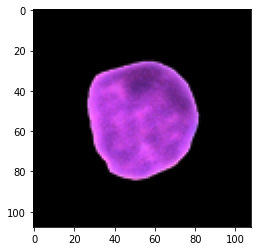

In [89]:
imshow(e[2])
imshow(e[2].astype('uint8'))

In [58]:
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu',input_shape=(108, 108,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit_generator(
    trainingData_generator,
    steps_per_epoch=floor(totalTrainImages//32),
    epochs=50,
    validation_data=validationData_generator,
    validation_steps=floor(totalValidationImages//32)
)

loss, accuracy = model.evaluate(validationData_generator,steps=floor(totalValidationImages//32))

Epoch 1/50


C:\Users\v4run\AppData\Local\Temp\ipykernel_19028\4170326710.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


111/111 [==============================] - 38s 335ms/step - loss: 1.7489 - accuracy: 0.6917 - val_loss: 0.5494 - val_accuracy: 0.7602
Epoch 2/50
111/111 [==============================] - 37s 337ms/step - loss: 0.5375 - accuracy: 0.7566 - val_loss: 0.4707 - val_accuracy: 0.8170
Epoch 3/50
111/111 [==============================] - 36s 327ms/step - loss: 0.4957 - accuracy: 0.7799 - val_loss: 0.4699 - val_accuracy: 0.8153
Epoch 4/50
111/111 [==============================] - 36s 326ms/step - loss: 0.4957 - accuracy: 0.7884 - val_loss: 0.4360 - val_accuracy: 0.8199
Epoch 5/50
111/111 [==============================] - 36s 325ms/step - loss: 0.4801 - accuracy: 0.8011 - val_loss: 0.4506 - val_accuracy: 0.8176
Epoch 6/50
111/111 [==============================] - 37s 329ms/step - loss: 0.4826 - accuracy: 0.7884 - val_loss: 0.4421 - val_accuracy: 0.8102
Epoch 7/50
111/111 [==============================] - 36s 326ms/step - loss: 0.4731 - accuracy: 0.7983 - val_loss: 0.4268 - val_accuracy: 0.8

In [59]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/model4.h5')

In [60]:
num_val_steps = floor(totalTrainImages//32)
print("Number of validation steps:", num_val_steps)

Number of validation steps: 111.0


In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
losses = history.history['loss']
val_loss = history.history['val_loss']

In [92]:
acc = np.round(acc,2)
val_acc = np.round(val_acc,2)

In [95]:
print(len(val_loss))
print(len(losses))

50
50


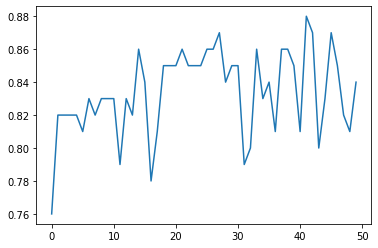

In [81]:
plt.plot(val_acc, label='Validation Accuracy')

In [82]:
epoch = range(1, len(acc)+1)

In [83]:
len(val_acc)

50

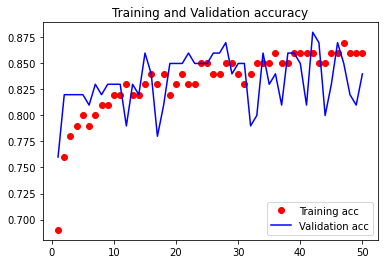

In [84]:
plt.plot(epoch, acc, 'ro', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

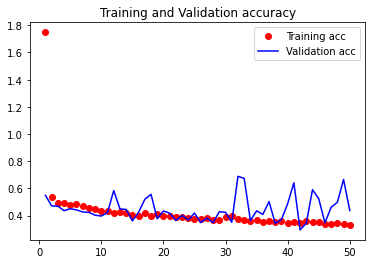

In [96]:
plt.plot(epoch, losses, 'ro', label = 'Training acc')
plt.plot(epoch, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

In [97]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 106, 106, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 11, 11, 128)     

In [109]:
from tensorflow.keras.models import Model

layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]

visualize_model = Model(inputs=model.inputs, outputs=[model.get_layer(name).output for name in layer_names])

In [ ]:
img_path = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2/all/UID_13_1_1_all.bmp'

In [111]:
image = Image.open(img_path)

In [145]:
img_resized = image.resize((128, 128)) #resize images (128*128, 256*256 etc)
img_array = exposure.equalize_adapthist(np.array(img_resized),clip_limit=0.03,nbins=256)
img_array = (img_array*255).astype(np.uint8)

img_array = np.array(img_array)
cropped_image = img_array[10:-10, 10:-10, :] 
img_label = 1
img_label = np.array([img_label])

In [146]:
img_label[0]

1

In [147]:
singleImage = np.expand_dims(cropped_image, axis=0)

In [148]:
dataAug = preprocessing.image.ImageDataGenerator()

In [150]:
dataAug.fit(singleImage)

In [151]:
dataAugmen = dataAug.flow(singleImage, img_label, batch_size=1)

In [152]:
a,b = next(dataAugmen)

In [135]:
imageProcessing = (cropped_image).astype(np.float32)
imageProcessing

array([[[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       ...,

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]]], dtype=float32)

In [154]:
activations = visualize_model(singleImage)

In [ ]:
activations

In [160]:
print(7/2)
print(floor(7//2))

3.5
3.0


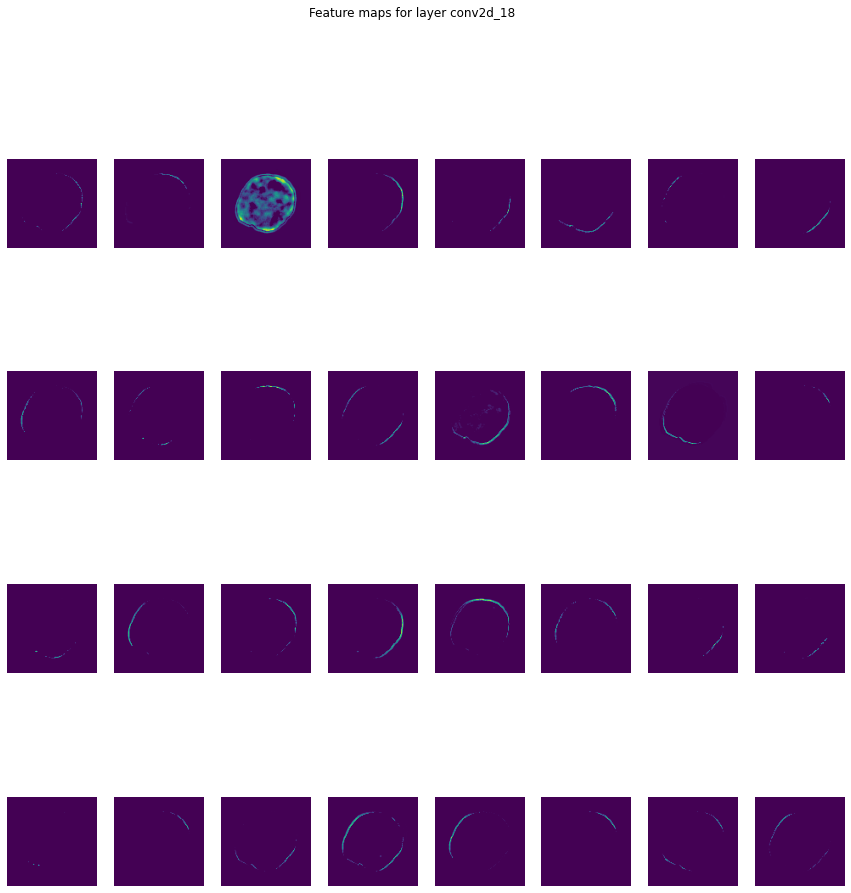

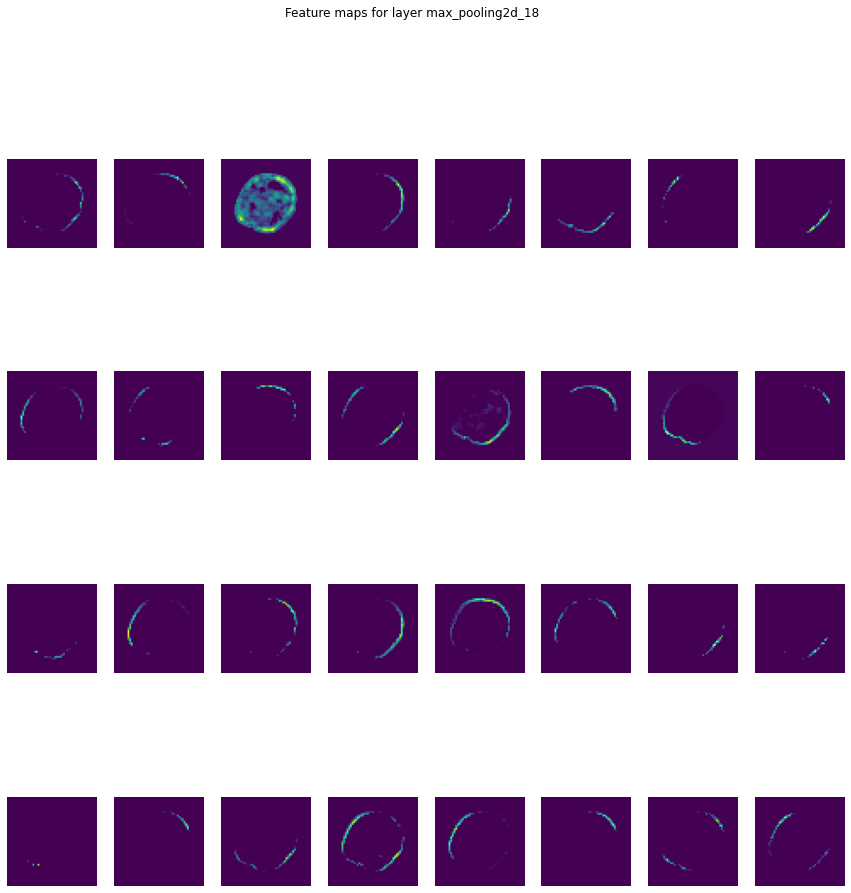

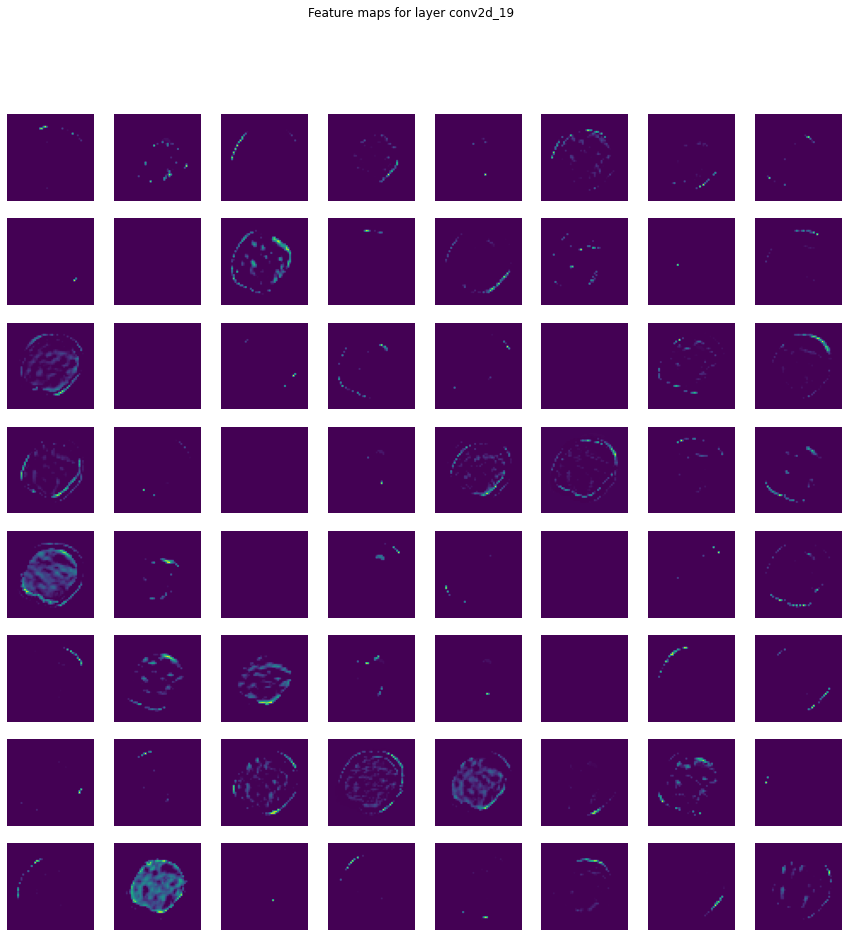

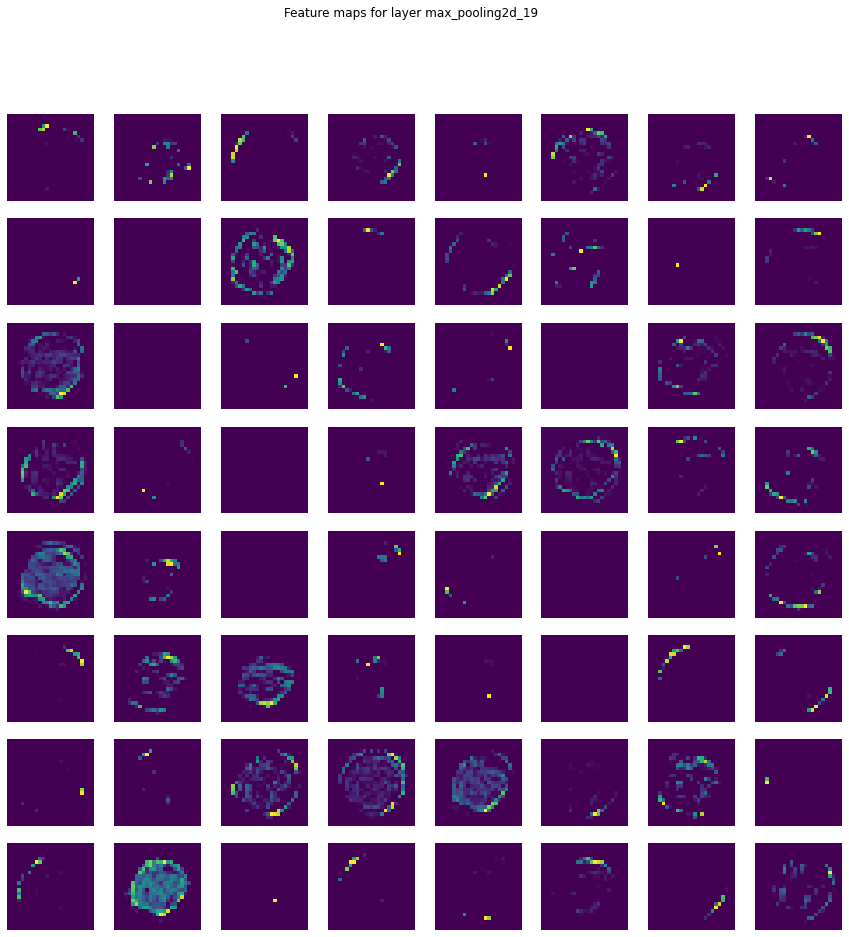

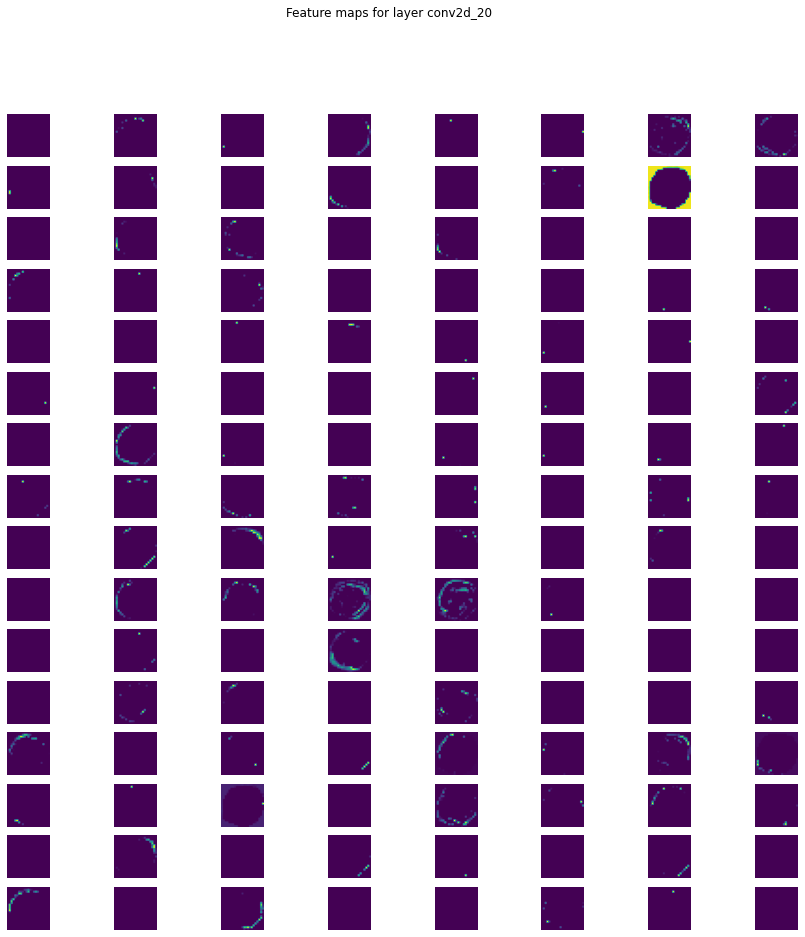

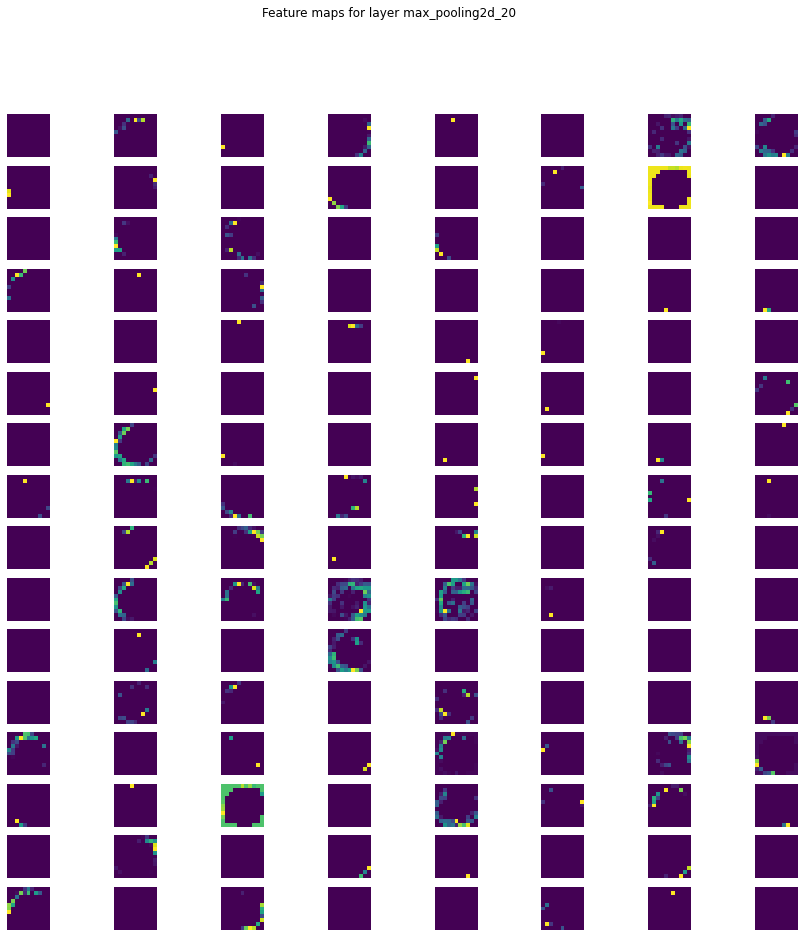

In [155]:
def display_feature_maps(activations, layer_names):
    for i, activation in enumerate(activations):
        layer_name = layer_names[i]
        num_filters = activation.shape[-1]

        # Calculate the number of rows and columns for the grid
        no_cols = 8
        grid_rows = num_filters // grid_cols

        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))
        fig.suptitle(f"Feature maps for layer {layer_name}")

        for j in range(num_filters):
            ax = axes[j // grid_cols, j % grid_cols]
            ax.imshow(activation[0, :, :, j], cmap='viridis')
            ax.axis('off')

        plt.show()

# Call the function with the activations and layer names
display_feature_maps(activations, layer_names)

# Testing

In [168]:
import bordercrop
import requests
import io

In [170]:
response = requests.get("https://i.imgur.com/lhQe6Bq.jpg")

cropped_image = Image.open(io.BytesIO(response.content))

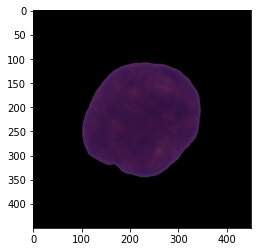

In [199]:
imshow(image)

(-0.5, 449.5, 449.5, -0.5)

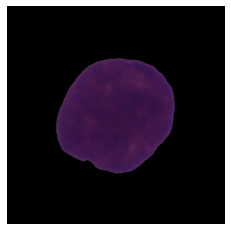

In [181]:
cropped_images = bordercrop.crop(image)
imshow(cropped_images)
axis('off')

In [178]:
# Import the library OpenCV
import cv2
  
# Import the image
# file_name = "gfg_black.png"
  
# Read the image
# src = cv2.imread(file_name, 1)
  
# Convert image to image gray
tmp = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
  
# Applying thresholding technique
_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
  
# Using cv2.split() to split channels 
# of coloured image
b, g, r = cv2.split(np.array(image))
  
# Making list of Red, Green, Blue
# Channels and alpha
rgba = [b, g, r, alpha]
  
# Using cv2.merge() to merge rgba
# into a coloured/multi-channeled image
dst = cv2.merge(rgba, 4)
  
# Writing and saving to a new image
# cv2.imwrite("gfg_white.png", dst)

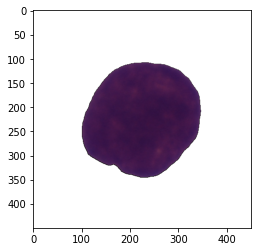

In [186]:
imshow(dst)
# axis('off')

In [190]:
savei = dst[int(449.5):int(-0.5), int(449.5):int(-0.5)]

In [191]:
cImage = Image.fromarray(savei)

In [196]:
import pydicom

In [244]:
def crop_img(images, display=False):
    mask = images == 0

    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    cropped_image = images[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]

    resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    return resized_image

In [245]:
croppedImage = crop_img(np.array(image))

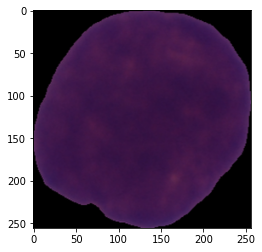

In [246]:
imshow(croppedImage)

In [247]:
img1 = Image.open('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2/all/UID_13_13_3_all.bmp')

In [248]:
croppedImage = crop_img(np.array(img1))

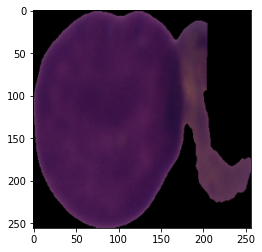

In [249]:
imshow(croppedImage)

In [234]:
croppedImage

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [235]:
croppedImage.resize((256,256))

ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False